In [2]:
#default_exp umap_all

# UMAP reduction of all COI

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [5]:
# export
import umap
from ehv import core, load as e_load, correlation
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
import uuid
from matplotlib import cm
from sklearn.neighbors import kneighbors_graph
import scipy.spatial.distance
import scipy.sparse
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.feature_selection import VarianceThreshold

In [6]:
samples = None
# samples = pandas.read_csv("data/selected_samples.csv")
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [130]:
df = df.filter(regex="(m0[1,4,6,7,11])|(ch0?[1,4,6,7,11])|meta")

In [7]:
df = df[df["meta_label_coi"]]
df.shape

(339045, 113)

In [8]:
orig_df = df.copy()

In [9]:
with open("data/selected_features_low.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [10]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [11]:
correlated_features = correlation.get_correlated_features(df.filter(regex="feat"), thresh=0.89)
df = df.drop(columns=correlated_features)
df.shape

(339045, 62)

In [12]:
df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))

In [13]:
df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))

In [176]:
def do_minmax_scale(df):
    df[df.filter(regex="feat").columns] = minmax_scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_minmax_scale)

In [177]:
def do_zscore_scale(df):
    df[df.filter(regex="feat").columns] = scale(df.filter(regex="feat"))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_zscore_scale)

In [40]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.05, 0.95))
    return df

df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(do_robust_scale)

In [169]:
def do_low_variance_filter(df):
    v = VarianceThreshold(0.01).fit(df.filter(regex="feat"))
    cols = df.filter(regex="feat").columns[v.get_support()]
    cols = cols.append(df.filter(regex="meta").columns)
    return df[cols]

df = do_low_variance_filter(df)

df.shape

(339045, 62)

## Compute UMAP on all cells of interest

In [178]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95).fit_transform(df.filter(regex="feat"))
pca.shape

(339045, 29)

In [179]:
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")

In [180]:
%%time
projection = model.fit_transform(pca)

CPU times: user 22min 50s, sys: 4min 52s, total: 27min 43s
Wall time: 5min 40s


In [181]:
dump(projection, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.dat']

In [14]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/c8ba196c-0b22-4489-9f9c-1242f68dd7a5.dat")

In [15]:
df["dim_1"] = projection[:, 0]
df["dim_2"] = projection[:, 1]

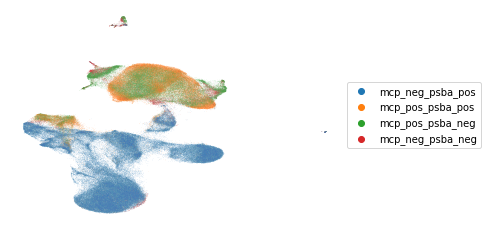

In [17]:
ax = seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", edgecolors="none", s=0.1, alpha=0.5, legend=True, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
# plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.jpg")
plt.savefig("figs/umap/labels.png", dpi=150, bbox_inches="tight")

<ipython-input-241-b28a0299bea0>:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("figs/umap/timepoints.png", dpi=150)
/opt/conda/envs/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


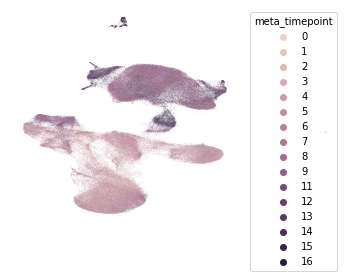

In [241]:
ax = seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_timepoint", s=0.1, edgecolors="none", alpha=0.5, legend="full")
ax.set_axis_off()
# plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.jpg")
plt.savefig("figs/umap/timepoints.png", dpi=150)

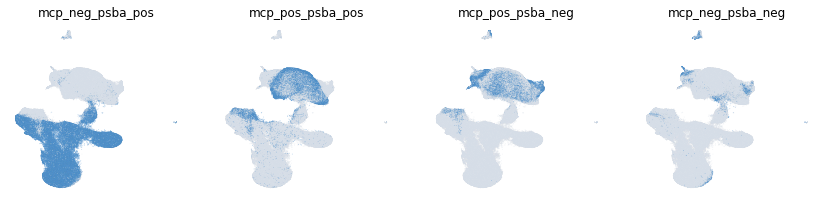

In [204]:
grid = seaborn.FacetGrid(data=df[df["meta_label"] != "unknown"].reset_index(), col="meta_label", col_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
cpal = seaborn.color_palette([(213/255, 221/255, 231/255), (29/255, 116/255,195/255)])

for col_name, ax in grid.axes_dict.items():
    ax.set_title(col_name)
    ax.set_axis_off()
    seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue=df["meta_label"]==col_name, hue_order=[False, True], s=0.5, alpha=0.5, ax=ax, legend=False, palette=cpal)

plt.savefig("figs/faceted_states_umap.png", dpi=150)

In [28]:
import matplotlib.colors
matplotlib.colors.to_rgba("gray", alpha=0.5)

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.5)

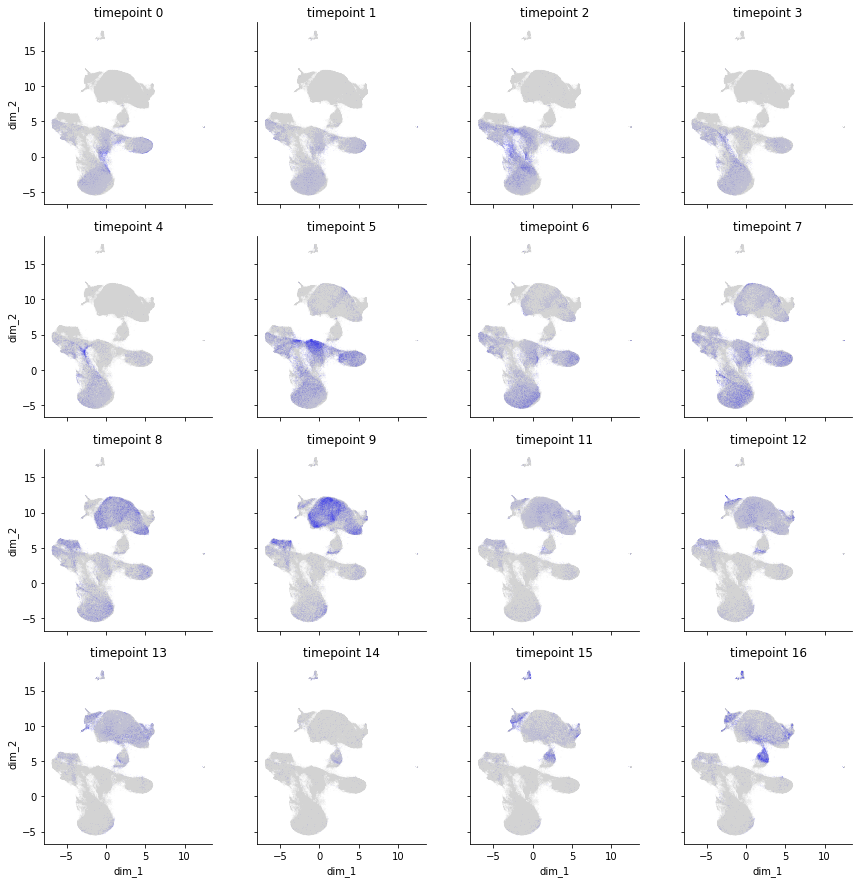

In [42]:
tmp_df = df
grid = seaborn.FacetGrid(data=tmp_df[tmp_df["meta_label"] != "unknown"].reset_index(), col_wrap=4, col="meta_timepoint", hue_order=sorted(tmp_df["meta_timepoint"].unique()))
cpal = seaborn.color_palette(["lightgray", "blue"])

for col_name, ax in grid.axes_dict.items():
    ax.set_title("timepoint " + str(col_name))
    seaborn.scatterplot(data=tmp_df, x="dim_1", y="dim_2", hue=tmp_df["meta_timepoint"]==col_name, hue_order=[False, True], s=0.1, alpha=0.5, edgecolors="none", ax=ax, legend=False, palette=cpal)
plt.savefig("figs/umap/timepoints.png", dpi=150)

In [ ]:
## export
def knn_umap_plot(df, ax, fig=None, colorbar=True, cmap="cool", metric="cosine"):
    knn = scipy.sparse.tril(kneighbors_graph(df.filter(regex="feat"), n_jobs=-1, n_neighbors=5, metric=metric)).toarray()
    dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(df[["dim_1", "dim_2"]], "euclidean"))
    
    norm = matplotlib.colors.Normalize(vmin=dists.min(), vmax=dists.max())
    cmap = cm.get_cmap(cmap)
    for i in range(knn.shape[0]):
        for j in knn[i].nonzero()[0]:
            xx = [df.iloc[i]["dim_1"], df.iloc[j]["dim_1"]]
            yy = [df.iloc[i]["dim_2"], df.iloc[j]["dim_2"]]
            ax.plot(xx, yy, alpha=0.2, c=cmap(norm(dists[i, j])), linewidth=.5)
            
    if colorbar:
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

CPU times: user 51.3 s, sys: 2.48 s, total: 53.8 s
Wall time: 49.2 s


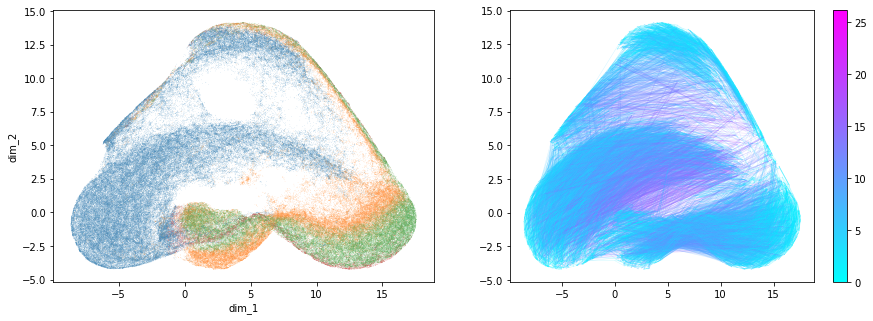

In [176]:
%%time
from sklearn.neighbors import kneighbors_graph
import scipy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
seaborn.scatterplot(data=df[df["meta_label"] != "unknown"], x="dim_1", y="dim_2", hue="meta_label", s=0.2, alpha=0.5, legend=False, ax=ax1, hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])

sample = df.sample(n=10000)
knn_umap_plot(sample, ax2, fig, True)

In [206]:
corr = df.filter(regex="feat|dim").corr()

In [233]:
corr["dim_2"].sort_values(ascending=False)[:20]

dim_2                                      1.000000
feat_area_m04                              0.696759
feat_bright_detail_intensity_r3_mc_ch04    0.607558
feat_intensity_mc_ch04                     0.605853
feat_bright_detail_intensity_r3_mc_ch03    0.591428
feat_area_m07                              0.542752
feat_modulation_m04_ch04                   0.503950
feat_contrast_m04_ch04                     0.454906
feat_length_m07                            0.423600
feat_area_mc                               0.415710
feat_width_m06                             0.398090
feat_bright_detail_intensity_r3_mc_bf      0.388407
feat_area_m06                              0.365111
feat_median_pixel_m01_bf                   0.321882
feat_length_m06                            0.316201
feat_width_m09                             0.299521
dim_1                                      0.273358
feat_modulation_m09_bf2                    0.261211
feat_length_m09                            0.235357
feat_width_m

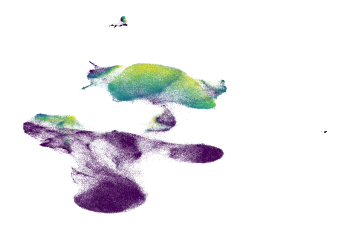

In [248]:
feat = "feat_area_m04"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/feat_area_m04.png", dpi=150)

In [237]:
corr["dim_2"].sort_values(ascending=True)[:20]

feat_aspect_ratio_m11                  -0.489875
feat_gradient_rms_m07_ch7              -0.451628
feat_max_pixel_mc_ch11                 -0.447926
feat_intensity_mc_ch11                 -0.430526
feat_aspect_ratio_intensity_m11_ch11   -0.358611
feat_aspect_ratio_intensity_m07_ch7    -0.352722
feat_aspect_ratio_intensity_m01_bf     -0.332405
feat_aspect_ratio_m01                  -0.321930
feat_aspect_ratio_m09                  -0.269384
feat_aspect_ratio_intensity_m09_bf2    -0.252734
feat_median_pixel_m09_bf2              -0.246859
feat_width_m11                         -0.219806
feat_area_m11                          -0.152526
feat_contrast_m07_ch7                  -0.112643
feat_modulation_m11_ch11               -0.088789
feat_gradient_rms_m06_ssc              -0.068932
feat_gradient_rms_m01_bf                0.028659
feat_contrast_m01_bf                    0.043450
feat_max_pixel_mc_ssc                   0.062402
feat_max_pixel_mc_bf2                   0.066518
Name: dim_2, dtype: 

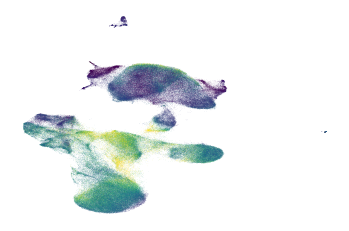

In [249]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/feat_intensity_mc_ch11.png", dpi=150)

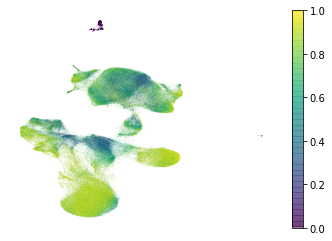

In [262]:
feat = "feat_aspect_ratio_m11"
norm = matplotlib.colors.Normalize(vmin=orig_df[feat].quantile(0), vmax=orig_df[feat].quantile(1))
plt.scatter(df["dim_1"], df["dim_2"], c=orig_df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.colorbar()
plt.axis("off")
plt.savefig("figs/umap/feat_aspect_ratio_m11.png", dpi=150)

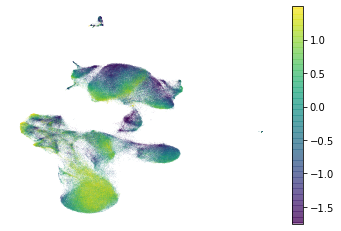

In [264]:
feat = "feat_gradient_rms_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.colorbar()
plt.axis("off")
plt.savefig("figs/umap/feat_gradient_rms_m07_ch7.png", dpi=150)

In [210]:
corr["dim_1"].sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_median_pixel_m01_bf                   0.394924
feat_gradient_rms_m01_bf                   0.331951
dim_2                                      0.273358
feat_area_m04                              0.228150
feat_aspect_ratio_intensity_m01_bf         0.208752
feat_aspect_ratio_intensity_m09_bf2        0.207804
feat_median_pixel_m09_bf2                  0.176673
feat_aspect_ratio_m09                      0.170938
feat_intensity_mc_ch04                     0.170684
feat_modulation_m04_ch04                   0.124939
feat_aspect_ratio_m01                      0.124581
feat_bright_detail_intensity_r3_mc_ch04    0.113842
feat_gradient_rms_m06_ssc                  0.084674
feat_area_m07                              0.081310
feat_contrast_m04_ch04                     0.058917
feat_length_m06                            0.049754
feat_bright_detail_intensity_r3_mc_ch03    0.036940
feat_length_m07                            0.027691
feat_width_m

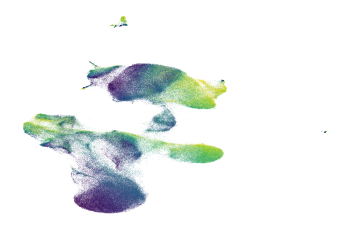

In [232]:
feat = "feat_median_pixel_m01_bf"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.1, edgecolors="none", alpha=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/feat_median_pixel_m01_bf.png", dpi=300)

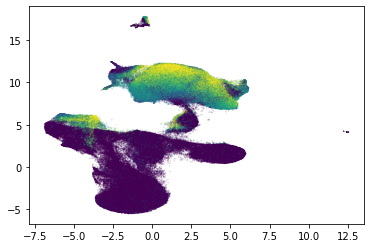

In [212]:
feat = "feat_area_m04"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, cmap="viridis", norm=norm)

In [213]:
corr["dim_1"].sort_values(ascending=True)[:20]

feat_max_pixel_mc_ssc                   -0.582263
feat_modulation_m01_bf                  -0.546697
feat_modulation_m06_ssc                 -0.485935
feat_intensity_mc_ssc                   -0.472959
feat_max_pixel_mc_bf2                   -0.414500
feat_max_pixel_mc_bf                    -0.402586
feat_contrast_m01_bf                    -0.377471
feat_contrast_m09_bf2                   -0.370689
feat_modulation_m09_bf2                 -0.285770
feat_gradient_rms_m07_ch7               -0.256260
feat_max_pixel_mc_ch11                  -0.208709
feat_intensity_mc_ch11                  -0.159292
feat_length_m01                         -0.149979
feat_width_m01                          -0.138073
feat_length_m09                         -0.128954
feat_contrast_m06_ssc                   -0.108029
feat_bright_detail_intensity_r3_mc_bf   -0.107066
feat_contrast_m07_ch7                   -0.104235
feat_modulation_m11_ch11                -0.086756
feat_aspect_ratio_m11                   -0.071491


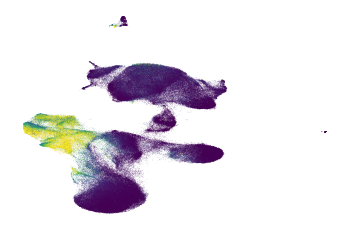

In [226]:
feat = "feat_max_pixel_mc_ssc"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
plt.scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.2, alpha=0.5, cmap="viridis", norm=norm, edgecolors="none")
plt.axis("off")
plt.savefig("figs/umap/feat_max_pixel_mc_ssc.png", dpi=150)